# Monte Carlo simulation of X-ray imaging

The two main interaction processes between photon and matter is the photoelectric effect and Compton scattering. The photoelectric effect is a process where an electron with energy E is absorbed by an atom. The process where a photon interacts with an outer electron of an atom, leading to a change in the photons energy and direction is known as Compton scattering. When taking these two effects into account, we assume that there is a probability p of a photon being absorbed or scattered when moving a small distance x to $x+\Delta x$. (And a probability of 1-p of it moving through unhindered.)
If we assume that the intensity of a photon beam is equal to $I(x)$, the above assumption would mean that the expected intensity of the beam at $x + \Delta x$ is equal to 

$I(x+\Delta x) = I(x)(1-p) + 0*p \,\,\,\,(1)$.

The first part of this notebook will look at x-ray imaging in one direction. The space it moves through is discretized into N different sections, where each distance is given by $\Delta x$. In this project the assumption that $p = \mu \Delta x$ will be made, where $\mu$ is the so-called attenuation coefficient. The attenuation coefficient describes the extent at which the radiant flux of a beam reduces as it moves through a material.

Rearranging the terms in (1), plugging in the definition of the probability p, and considering infitesimal steps ($\Delta x \rightarrow 0$), we get the differential equation

$\frac{dI(x)}{dx} = -\mu I(x) \,\,\,\,(2)$.

This equation has the analytical solution 

$I(x) = I_0 e^{-\mu x} \,\,\,\, (3)$,

where $I_0$ is the initial intensity of the beam. This analytical solution will be used to measure how good the numerical approximation is.

For the later parts of the project, some data of attenuation coefficients will be used. These are structured in datafiles giving the attenuation coefficient of the different materials for different energies.

In [22]:
#%matplotlib notebook
# Importing necessary libraries
import numpy as np # Numpy for handling arrays
import matplotlib.pyplot as plt # Matplotlib to do the plotting
from mpl_toolkits.mplot3d import Axes3D # For 3D plots
from IPython.display import HTML, display # For tables
import tabulate # Tables
import simulation_functions as sf
from numba import jit #just in time compilation - faster code

# Fixing some parameters for all of the figures
plt.rcParams.update({'axes.grid': True, 'grid.linestyle' : "--", 'figure.figsize' : (9.5,6)})

In [23]:
%%html 
<style>
.output_wrapper button.btn.btn-default, .output_wrapper .ui-dialog-titlebar {
    display: none;
} </style>

Above block is just to remove the interactive buttons that comes with the notebook backend to get cleaner figures.

### Part 1

In this part a one-dimensional beam of photons will be sent through a material with dampening coefficient, $\mu$.
The result from the Monte-Carlo method and the analytical solution will be compared.
In the end the stability of the Monte-Carlo method will be looked into by comparing different number of photons and different steplengths $\Delta x$. This part is mainly to check that the numerical solver corresponds with the analytical solution.

In [24]:
# Defining some parameters for the first part
# Adding _1 to the parameters to keep them separated from the other parts
'''
- width: the width of the material (cm)
- n_steps: the number of steps
- x: the points along the x-axis
- n_photons: number of photons
- my: the attenuation coefficient of the material, cm^-1
'''

width_1 = 10
n_steps_1 = 100
x_1 = np.linspace(0, width_1, n_steps_1 + 1)
n_photons_1 = 10000
my1 = 0.1 * np.ones(n_steps_1)

In [25]:
# In both the numerical and the analytical solution, the intensity is scaled to 1

# Numerical simulation given the parameters above
I1 = sf.simulate_photons(n_photons_1, n_steps_1, width_1, my1) 

# Analytical solution given the parameters:
I_analytical = np.exp(-my1[0] * x_1) # For this part we assume attenuation coefficient to be constant

#### Figure 1: Comparison between Monte Carlo method and Analytical solution

In the figure below the accuracy of the numerical simulation is shown for different number of photons.

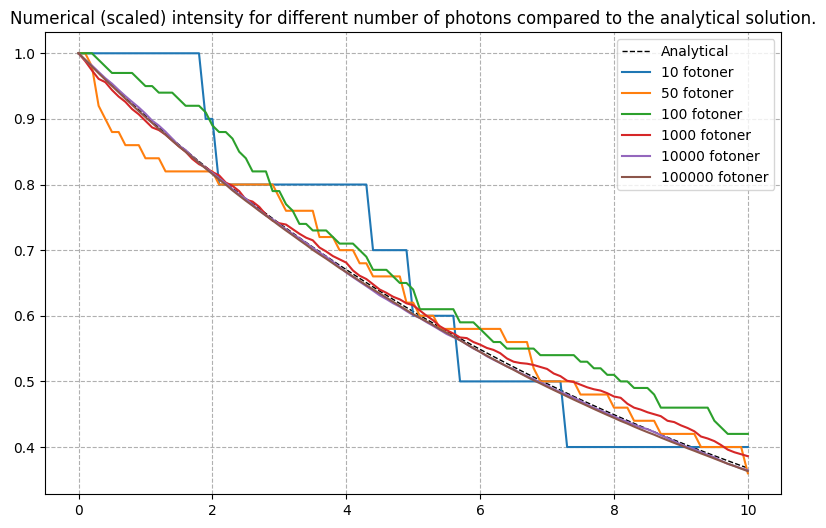

In [26]:
# Comparing the analytical solution with the numerical solution
fig1 = plt.figure()
plt.plot(x_1, I_analytical, label = 'Analytical', linestyle = '--', color = 'black', linewidth = 1)

number_of_photons = [10, 50, 100, 1000, 10000, 100000]

for i, n_photon in enumerate(number_of_photons):
    # Going through the different numbers of photons
    I_numerical = sf.simulate_photons(n_photon, n_steps_1, width_1, my1)
    plt.plot(x_1, I_numerical, label = f"{n_photon} fotoner")
plt.title("Numerical (scaled) intensity for different number of photons compared to the analytical solution.")
plt.legend()
plt.show()

From the plot above it is clear to see that as the number of photons in the photon beam increases, the Monte Carlo approximation approaches the analytical solution. 

Now, the numerical approximation and the analytical solution will be compared more accurately. To this end the function to simulate photons will be run a thousand times for each different number of photons. Afterwards, the mean distance and standard deviation from the analytical solution calculated.

In [27]:
tabell = []
for i, n_photon in enumerate(number_of_photons):
    distance = np.zeros(n_steps_1 + 1)
    for j in range(1000):
        I = sf.simulate_photons(n_photon, n_steps_1, width_1, my1)
        
        distance += abs(I_analytical - I) # Summing up the total distances of all the runs
    
    # Calculate averages and standard deviations
    mean_error = np.mean(distance/1000) 
    std_error = np.std(distance/1000)
    
    # Adding result to table for easier
    tabell.append([f"{n_photon}", round(mean_error, 4), round(std_error, 4)])
    
# Using library tabulate to get a good looking table
# Changing the html code to get a centered table
display(HTML('<table width="80%" style="margin: 0px auto;"><thead><tr><th style="text-align: center;">' 
      + tabulate.tabulate(tabell, headers=["Photons", "Mean error I/I0", "Standard deviation I/I0"], 
                               tablefmt="html")[52:-8] + "</table>"))

Photons,Mean error I/I0,Standard deviation I/I0
10,0.1137,0.0267
50,0.051,0.0123
100,0.0348,0.0081
1000,0.0111,0.0026
10000,0.0037,0.0009
100000,0.0016,0.0005


From the table above, it is clear that as the number of photons increases, the error and standard deviation decreases. The difference from 10,000 to 100,000 is not that big, but the run time is much greater. This means that it might be more efficient to use 10,000 for later simulations.

#### Figure 2
The number of photons used in the simulation is not the only parameter that can effect the quality of the numerical approximation. The grid size, i.e. the number of steps used in the simulation is also important.

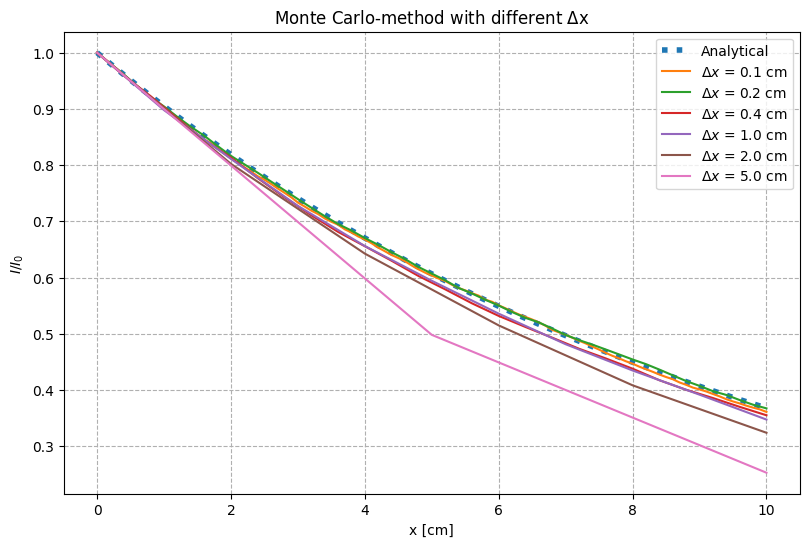

In [28]:
fig2 = plt.figure()
plt.plot(x_1, I_analytical, label = "Analytical", linestyle = 'dotted', linewidth = 4)
n_steps_1_2 = [100, 50, 25, 10, 5, 2] # Different number of steps to compare
dx1_2 = width_1 / np.array(n_steps_1_2)

# Simulate 100,000 photons through the material with the steplengths definied above
for i, n_step in enumerate(n_steps_1_2):
    x1_2 = np.linspace(0, width_1, n_step + 1) # Need new x-axis for each simulation
    my1_2 = 0.1 * np.ones(n_step) # Dimension of my changes with number of steps
    I = sf.simulate_photons(n_photons_1, n_step, width_1, my1_2) # Do the simulation
    
    plt.plot(x1_2, I, label = f"$\Delta x$ = {dx1_2[i]} cm")

plt.title("Monte Carlo-method with different $\Delta$x"); plt.xlabel("x [cm]"); plt.ylabel("$I/I_0$"); plt.legend()
plt.show()

From the plot above it is apparent that a large number of steps (a small steplength) is needed to capture the curvature of the analytical solution. 

### Part 2

In this part two different photon beams will be simulated. One will go through only tissue, and the other will first go through tissue, then through bone and in the end through tissue again. All three layers have the same thickness. Their contrast will be compared at different energy levels. The attenuation of bone and tissue at different energies is given in the data folder.
The data file for bone was collected from 
https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/bone.html,

and the data file for (soft) tissue was collected from
https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/tissue.html.

The first column contains the energy, and the second one the mass-attenuation coefficient. To get back the attentuation coefficient 
$\mu $, these values will have to be devided by the density, $\rho$. I will use $\rho_{tissue} = 1.02 g/cm^3$ and $\rho_{bone} = 1.92 g/cm^3$.

This part of the project is supposed to simulate x-rays, where some of the rays will move through some soft tissue and some bone, and others will move through only tissue. After the simulation is finished, the difference in concentration will be compared to see if any contrast may be visible.

Since the energy of x-rays used in medicine lies between 10keV and 100keV, the simulations in this part will consider energies in this range.

In [29]:
# Constants for part 2
tissue_dens = 1.02 #g/cm^3
bone_dens = 1.92 #g/cm^3
n_steps_2 = 1000
width_2 = 3 #cm
n_photons_2 = 100000

# reading in the datafiles for attenuation coefficients
energy_tissue, mu_tissue = np.loadtxt("data/tissue.txt", delimiter=',', unpack=True)
energy_bone, mu_bone = np.loadtxt("data/bone.txt", delimiter=',', unpack=True)

# Multiplying with density to get correct attenuation coefficient
mu_tissue *= tissue_dens
mu_bone *= bone_dens

#### Figure 3: Attenuation coefficients as function of energy

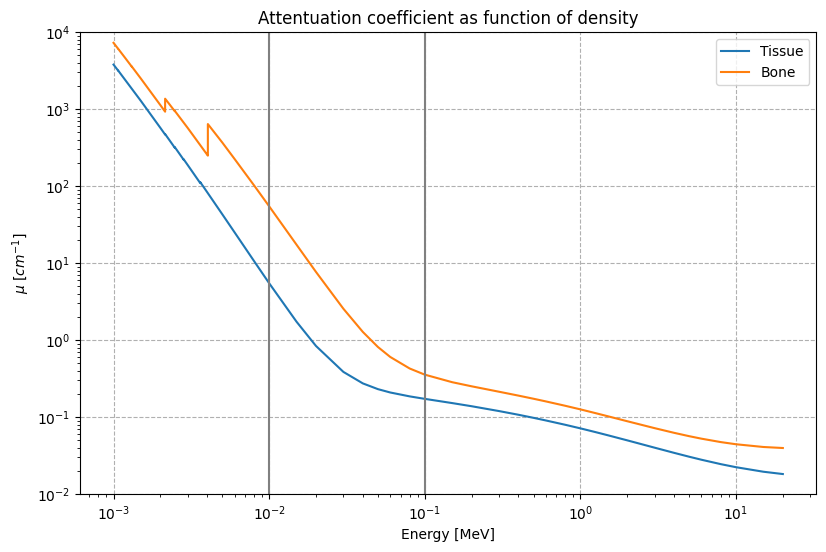

In [30]:
fig3 = plt.figure()
energy_lower, energy_higher = 1e-2, 1e-1
plt.loglog(energy_tissue, mu_tissue, label = "Tissue")
plt.loglog(energy_bone, mu_bone, label = "Bone")
plt.title("Attentuation coefficient as function of density")
plt.xlabel("Energy [MeV]"); plt.ylabel("$\mu$ $[cm^{-1}]$"); plt.legend(); plt.ylim(1e-2, 1e4)
plt.vlines(energy_lower, 0, 1e4, color = "grey"); plt.vlines(energy_higher, 0, 1e4, color = "grey")
plt.show()

Now the two beams of photons will be sent through tissue and a combination of bone and tissue respectively. Since the attenuation coefficient of bone is higher than the coefficient for tissue, it is expected that a higher percentage of the photon beam will be absorbed when moving through bone than the tissue.

In [31]:
# Creating a list of energies that are contained in both bone and tissue data, and are within interval
energies = energy_tissue[(energy_tissue <= energy_higher) & (energy_tissue >= energy_lower)] 

# Two lists to store intensity at the detector for each energy level
I_tissue_detector = np.zeros(len(energies)) #I1: kun vev
I_bone_detector = np.zeros(len(energies)) #I2: vev-bein-vev

# Also storing intensity for the second beam after tissue part and after bone part
I_after_tissue = np.zeros(len(energies))
I_after_bone = np.zeros(len(energies))

for i, energy in enumerate(energies):
    # Collecting the correct attenuation coefficients for each of the two 
    index_tissue = np.where(energy_tissue == energy)[0][0] 
    index_bone = np.where(energy_bone == energy)[0][0]

    # Transforming the coefficient to lists of length equal to number of steps
    mu_tissue_i = mu_tissue[index_tissue] * np.ones(n_steps_2)
    mu_bone_i = mu_tissue_i.copy()
    
    # Filling in the bone region
    mu_bone_i[n_steps_2 // width_2 : 2 * n_steps_2 // width_2] = mu_bone[index_bone]

    # Simulating n_photons_2 number of photons through the different materials
    I_tissue_detector[i] = sf.simulate_photons(n_photons_2, n_steps_2, width_2, mu_tissue_i)[-1]
    I_bone_beam = sf.simulate_photons(n_photons_2, n_steps_2, width_2, mu_bone_i)
    I_bone_detector[i] = I_bone_beam[-1]
    I_after_tissue[i] = I_bone_beam[n_steps_2//3]
    I_after_bone[i] = I_bone_beam[(2*n_steps_2)//3]

#### Figure 4: Difference in intensity for photons moving through bone and tissue

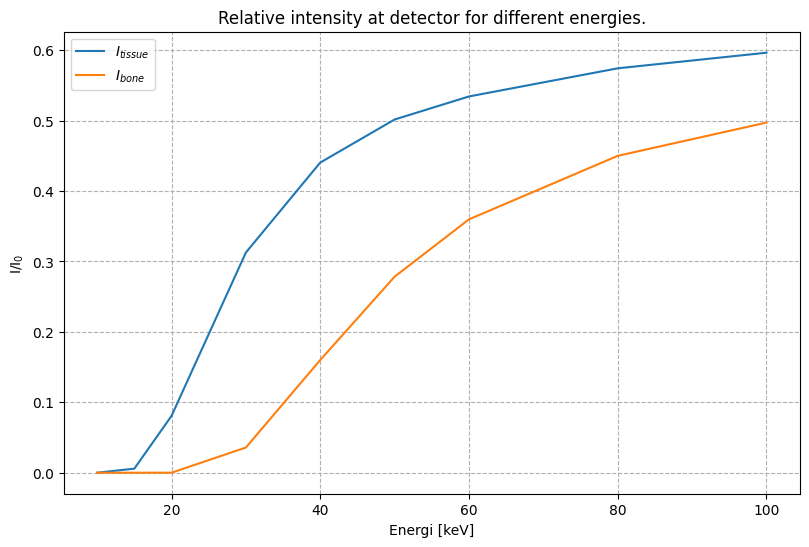

In [32]:
fig4 = plt.figure()
plt.plot(energies*1000, I_tissue_detector, label = "$I_{tissue}$")
plt.plot(energies*1000, I_bone_detector, label = "$I_{bone}$")
plt.title("Relative intensity at detector for different energies.")
plt.xlabel("Energi [keV]"); plt.ylabel("I/I$_0$"); plt.legend()
plt.show()

From the plot above it is clear that the intensity of the beam going only through the tissue is bigger at the detector. The difference is biggest around 30-40 keV. However, instead of considering the difference directly, it is probably more usefull to look at the contrast.

#### Figure 5: Contrast between beam going through tissue and beam through tissue and bone.

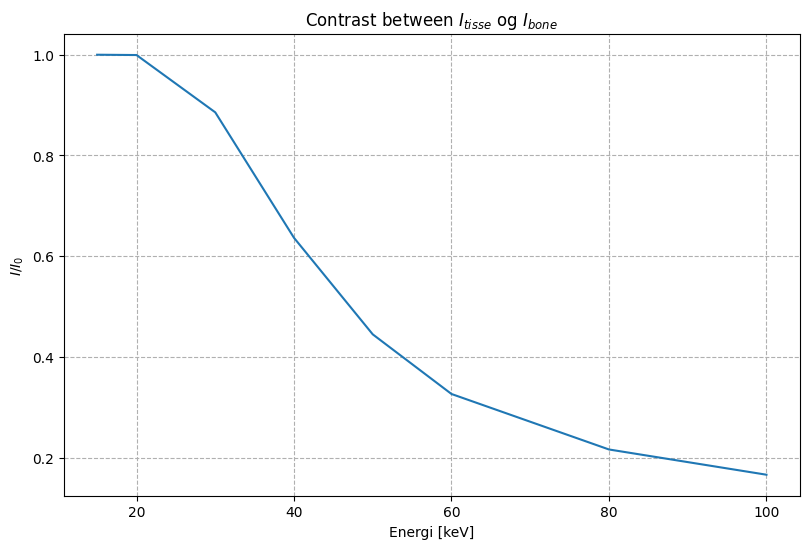

In [33]:
fig5 = plt.figure()
contrast = np.zeros(len(I_bone_detector))
for i in range(len(I_tissue_detector)):
    contrast[i] = (I_tissue_detector[i] - I_bone_detector[i]) / I_tissue_detector[i]

plt.plot(energies[1:]*1000, contrast[1:])
plt.title("Contrast between $I_{tisse}$ og $I_{bone}$")
plt.xlabel("Energi [keV]"); plt.ylabel("$I/I_0$")
plt.show()

The contrast looks to be the biggest for lower energy photon beams (but high enough energy for the photons to get through). It seems reasonable that the contrast starts at 1, since at 15keV some photons are able to move through the tissue, but not the bone.

It might also be interesting to get an idea of how many photons are required for the detector to be able to detect the beam after it has passed through. If we assume that an intensity of 10MeV is required for the detector to be able to detect a signal, we can use the previously calculated results to find the necessary number of photons.

Since the intensity of the tissue beam for the first energy and the intensity of the bone beam for the two first energies are numerically zero, they cannot be used to find the correct number of photons.

In [34]:
req_photons_tissue = 10 / (I_tissue_detector[1:] * energies[1:])
req_photons_bone = 10 / (I_bone_detector[2:] * energies[2:])
req_photons = 10 / energies[1:]

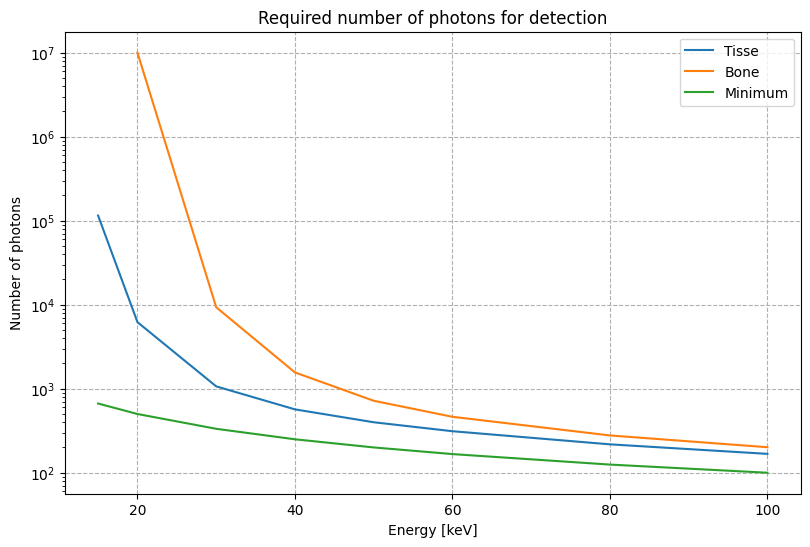

In [35]:
fig6 = plt.figure()
plt.semilogy(energies[1:]*1000, req_photons_tissue, label="Tisse")
plt.semilogy(energies[2:]*1000, req_photons_bone, label = "Bone")
plt.semilogy(energies[1:]*1000, req_photons, label = "Minimum")
plt.title("Required number of photons for detection")
plt.xlabel("Energy [keV]"); plt.ylabel("Number of photons")
plt.legend()
plt.show()

As expected, the plots show that a higher number of photons are required for the beam travelling through bone. Furthermore, as the energy increases and the percentage of photons passing through increases, the slopes flatten out and the distance to the minimal number of photons decreases.

As mentioned before the overall goal is to maximize the contrast, while also minimizing the quantity of absorbed photons. For simplicity we will for the moment ignore Compton-scattering and assume that all of the photons that doesn't make it through the material are absorbed. Even though this is a rough approximation, it can give a good idea of which energy region that gives the best trade-off between a good contrast and a small absorbed dosage.
The absorbed dosage is given by equation (4). For the beam that passes through 1/3 tissue, 1/3 bone and 1/3 tissue, we must know how many photons that were absorbed in each of the three sections.

In [36]:
# Calculating the number of photons that reached detector and each of the 
# sections in the tissue and tissue/bone beams
n_photon_tissue = I_tissue_detector[1:] * req_photons_tissue
n_photon_bone = I_bone_detector[1:] * req_photons_tissue
n_photon_after_tissue = I_after_tissue[1:] * req_photons_tissue # After the tissue part
n_photon_after_bone = I_after_bone[1:] * req_photons_tissue # After bone part

n_absorbed_tissue = req_photons_tissue - n_photon_tissue # Absorbed photons for the tissue beam

# Calculating the number of photons absorbed in the second beam after each of the sections
n_in_tissue = req_photons_tissue - n_photon_after_tissue
n_in_bone = n_photon_after_tissue - n_photon_after_bone
n_absorbed_bone = n_photon_after_bone - n_photon_bone

A = 1 # Choosing area of 1 cm^2
V = A * width_2 #cm^3
# Calculating the total absorbed dosages for the two beams
d_tissue = n_absorbed_tissue * energies[1:] / (V * tissue_dens)
d_bone = energies[1:] / V * ((n_in_tissue / (1/3 * tissue_dens))
                         +  (n_in_bone / (1/3 * bone_dens)) 
                         +  (n_absorbed_bone / (1/3 * tissue_dens))) 

In [37]:
print(d_tissue)
print(d_bone)

[561.14892704  37.24744712   7.18586273   4.15384177   3.24920438
   2.84999427   2.42417039   2.21290473]
[1553.6686393    96.91225393   21.05724471   12.97754791   10.04492478
    8.59980794    7.07776514    6.3263709 ]


#### Figure 7: Total absorbed dosage in tissue and bone

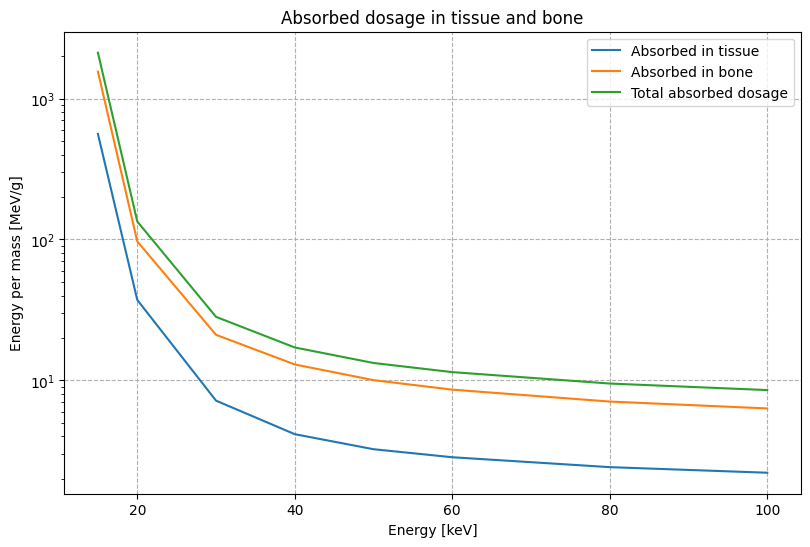

In [38]:
fig7 = plt.figure()
plt.semilogy(energies[1:]*1000, d_tissue, label = "Absorbed in tissue")
plt.semilogy(energies[1:]*1000, d_bone, label  = "Absorbed in bone")
plt.semilogy(energies[1:]*1000, d_tissue+d_bone, label = "Total absorbed dosage")
plt.legend()
plt.title("Absorbed dosage in tissue and bone")
plt.xlabel("Energy [keV]")
plt.ylabel("Energy per mass [MeV/g]")
plt.show()

The plot shows that the absorbed dosage decreases as the increases. This might seem counterintuitive, but comes from the fact that the number of photons is fixed so that the energy at the detector of the beam moving through tissue is constant.

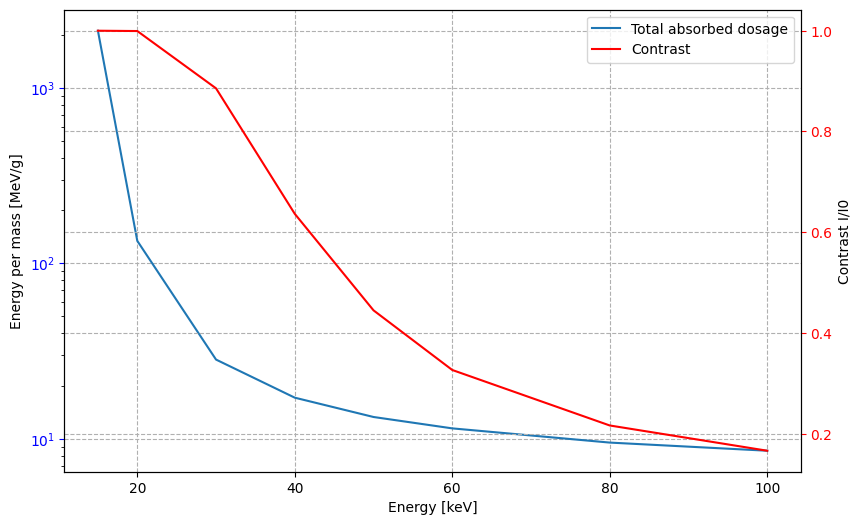

In [39]:
fig8, axes8 = plt.subplots()
plt8 = axes8.semilogy(energies[1:]*1000, d_tissue+d_bone, label = "Total absorbed dosage")
axes8_2 = axes8.twinx()
plt8_2 = axes8_2.plot(energies[1:]*1000, contrast[1:], color = "red", label = "Contrast")
axes8.set_xlabel("Energy [keV]")
axes8.set_ylabel("Energy per mass [MeV/g]")
axes8_2.set_ylabel("Contrast I/I0")

ls = [l.get_label() for l in (plt8 + plt8_2)]
axes8_2.legend(plt8 + plt8_2, ls)
axes8.tick_params(axis="y", colors="blue")
axes8_2.tick_params(axis="y", colors="red")
plt.show()

The figure shows the absorbed dosage and the contrast for energy levels ranging from 20keV to 100keV. Since a high contrast and a low absorbed quantity is to be desired, it is difficult to know how to choose the best combination. The absorbed dosage decreases quickly untill an energy level of 30keV and the contrast is quite high untill energy levels of 40-50 keV. Therefore it might be that the optimal energy level is somewhere between 30keV and 40keV.

### Part 3
In this part photon beams will be sent through different 3d objects at different energies instead of the 2d objects from before. 2d images will be created by sending the photon beams through the three different axes.
The matrices describing the attenuation coefficient of two unspecified objects at different grid points can be found in the data folder. The 3d objects have one matrix for different energy levels. From these matrices the goal is to figure out which object is described by sending photons through the material from different directions. To this end, the most interesting quantity to measure is how many photons reach the detector after passing through the material.

In [40]:
# Constants for part 3
n_photons_3 = 1000

# Reading in the 3d-objects
objects1 = np.array([np.load("data/object1_20keV.npy"), 
                      np.load("data/object1_50keV.npy"), 
                      np.load("data/object1_100keV.npy")])

objects2 = np.array([np.load("data/object2_25keV.npy"), 
                      np.load("data/object2_50keV.npy"), 
                      np.load("data/object2_75keV.npy")])

# Energies of photon beams
energies3_1 = np.array([20, 50, 100])
energies3_2 = np.array([25, 50, 75])

# Widths of objects in x, y, z direction (cm).
widths3_1 = np.array([6.5, 44.6, 44.6])
widhts3_2 = np.array([12, 12, 10])

In [41]:
# Simulating the photon beams through the two objects
object_1, object_2 = [], []
for i in range(3):
    object_1.append(sf.simulate_photons_3D(n_photons_3, objects1[i], widths3_1))
    object_2.append(sf.simulate_photons_3D(n_photons_3, objects2[i], widhts3_2))
    
objects = [object_1, object_2]

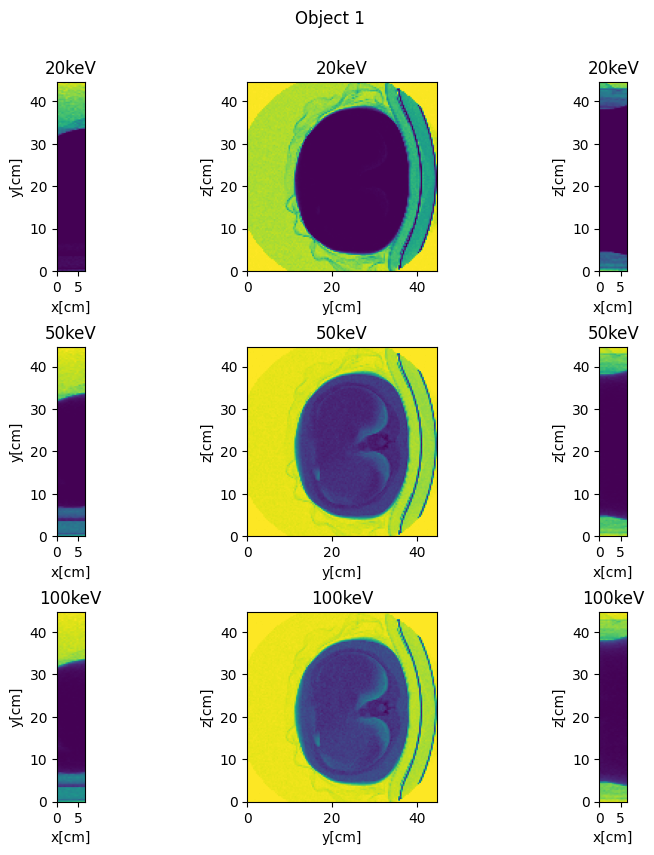

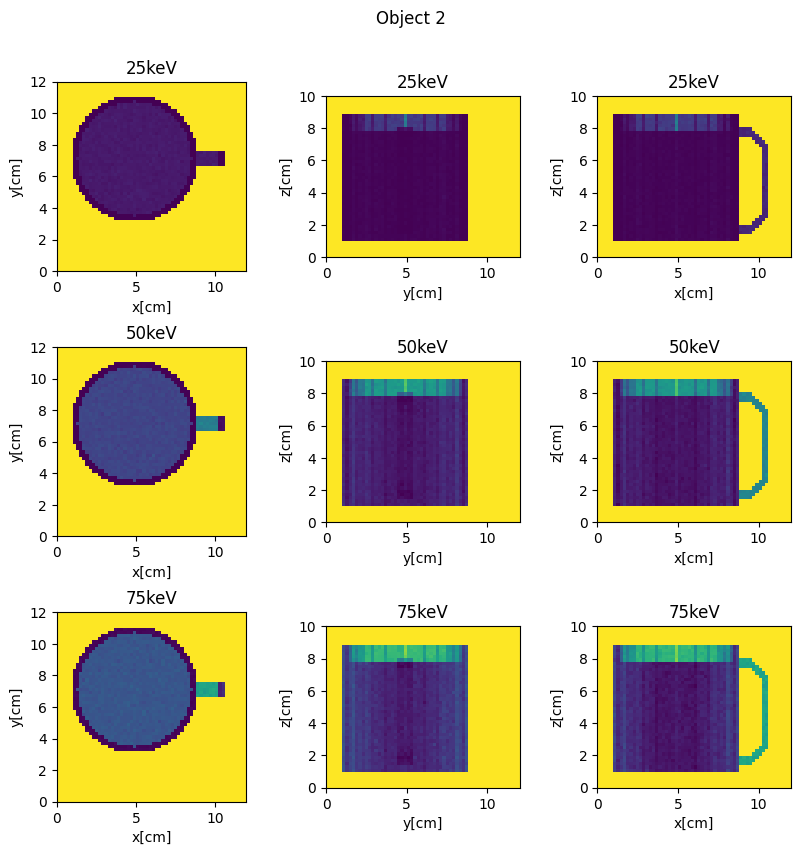

In [42]:
x_labs = ["x[cm]", "y[cm]", "x[cm]"]
y_labs = ["y[cm]", "z[cm]", "z[cm]"]
energy_labs = [["20keV", "50keV", "100keV"], ["25keV", "50keV", "75keV"]]
extents = [[[0, 6.5, 0, 44.6], [0, 44.6, 0, 44.6], [0, 6.5, 0, 44.6]],
           [[0, 12, 0, 12], [0, 12, 0, 10], [0, 12, 0, 10]]]

for i in range(len(objects)):
    figur12, akser12 = plt.subplots(nrows = 3, ncols = 3, figsize= (9.5, 9))
    figur12.suptitle(f"Object {i+1}")
    figur12.subplots_adjust(bottom = 0.1, top = 0.9, hspace = 0.4, wspace = 0.4)
    for j in range(3):
        for k  in range(3):
            akser12[j, k].grid(False)
            akser12[j,k].set_xlabel(x_labs[k])
            akser12[j,k].set_ylabel(y_labs[k])
            akser12[j,k].set_title(energy_labs[i][j])
            akser12[j, k].imshow(objects[i][j][k].T, extent = extents[i][k])
plt.show()

The first object seems to to display some organic matter. It is difficult to say for sure, but it could be a section of the thorax. The photon beams going through the yz-plane gives the most information about the object. The attenuation coefficient varies with energy, which is the reason the plots for the different energies look different. 
Lower energies make the wavy parts more visible, whereas higher energies gives higher contrast between sections in the interior. Depending of what is of interest, different energy levels may be appropriate.
The images of the first object look quite similar to how traditional x-ray images might look.

The second object seems to be a coffee mug. The mug is visible for all energy levels, but a higher energy level gives a higher contrast between the edge of the mug and the interior of the mug. The brighter line at the top of the mug might mean that it is filled with coffe up to that point.